# Initialization, Making the Preprocessor, and Making the Processed Training File

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Save and read data files from your GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load training .csv file
old_training_doc_df = pd.read_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/topic_model_train_new.csv')

In [ ]:
spacy_lemma = spacy.load("en_core_web_sm")
def my_preprocessor(text):
  """
  Parameters:
    text: (str)

  Changes:
    Converts text to lowercase
    Removed Markdown code
    Removed numbers
    Removed stop words (english and spanish)
    Removed parentheses (and everything inside them)
    Removed punctuation
    Lemmatizes

  """

  # Makes text lowercase
  text_lower = text.lower()

  # Remove parentheses and anything inside them
  text_paren = re.sub(r'\(.*?\)', '', text_lower)

  # Remove numbers
  text_num = re.sub(r'\d+', '', text_paren)

  # Remove markdown / LaTeX code (starts with '\' or '$' or contain underscores)
  text_clean = re.sub(r'[\$\\]\S+|\b\w*_\w*\b', '', text_num)

  # Split text into words (also gets rid of punctuation)
  tokens = RegexpTokenizer(r'\w+').tokenize(text_clean)

  # Define stop words
  stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish'))

  # Removes stopwords
  stopunct_tokens = []
  for token in tokens:
    if token not in stop_words:
      stopunct_tokens.append(token)

  # Combines text for and processes with SpaCy
  text_processed_0 = ' '.join(stopunct_tokens)
  text_spacy = spacy_lemma(text_processed_0)

  # Lemmatization
  pos_tags = {'NOUN', 'ADJ', 'VERB', 'ADV'}
  lemma_tokens = []
  for token in text_spacy:
    if token.pos_ in pos_tags:
      lemma_tokens.append(token.lemma_)

  common_words = [
      'approach',
      'consider',
      'define',
      'different',
      'feature',
      'first',
      'general',
      'however',
      'known',
      'method',
      'network',
      'number',
      'obtain',
      'present',
      'problem',
      'propose',
      'provide',
      'result'
  ]

  # Keep words > 4 letters and rid of common words with little meaning
  final_tokens = []
  for token in lemma_tokens:
    if len(token) > 5 and token not in common_words:
      final_tokens.append(token)

  # Make one string again
  text_processed = ' '.join(final_tokens)

  return text_processed

In [ ]:
# Make and save the processed training file (if doesn't exist yet)
file_path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/training_processed.csv'
if os.path.exists(file_path):
  train_df = pd.read_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/training_processed.csv')
  print('File Already Exists. Continue.')
else:
  train_df = old_training_doc_df.copy()
  train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(my_preprocessor)
  path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/'
  train_df.to_csv(f'{path}training_processed.csv', index=False)

File Already Exists. Continue.


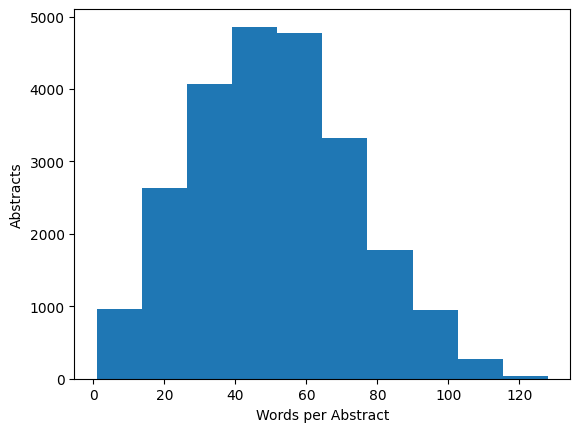

In [ ]:
# Show a histogram of the word count per abstract
train_df['ABSTRACT_word_count'] = train_df['ABSTRACT'].apply(lambda x: len(str(x).split(" ")))
plt.hist(train_df['ABSTRACT_word_count'])
plt.xlabel("Words per Abstract")
plt.ylabel("Abstracts")
plt.show()

In [ ]:
# Look at two examples of processed vs. not processed
for i in range(2): # Use to see first Abstract
    abstract = old_training_doc_df['ABSTRACT'].iloc[i]
    print(f'Abstract {i+1} (Not Processed):', abstract)
    abstract = train_df['ABSTRACT'].iloc[i]
    print(f'Abstract {i+1} (Processed):', abstract, '\n')

Abstract 1 (Not Processed):   Rotation invariance and translation invariance have great values in image
recognition tasks. In this paper, we bring a new architecture in convolutional
neural network (CNN) named cyclic convolutional layer to achieve rotation
invariance in 2-D symbol recognition. We can also get the position and
orientation of the 2-D symbol by the network to achieve detection purpose for
multiple non-overlap target. Last but not least, this architecture can achieve
one-shot learning in some cases using those invariance.

Abstract 1 (Processed): rotation invariance translation invariance recognition architecture convolutional neural cyclic convolutional achieve rotation invariance symbol position orientation symbol achieve detection purpose multiple overlap target architecture achieve invariance 

Abstract 2 (Not Processed):   We introduce and develop the notion of spherical polyharmonics, which are a
natural generalisation of spherical harmonics. In particular we study t

# Sentence Embedding (SBERT - "allenai-specter") on the Training Set

### Initialization

In [ ]:
!pip install -U sentence-transformers
import scipy.cluster.hierarchy as sch
from nltk.tokenize import word_tokenize
from scipy.spatial import distance
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

### Making the SBERT Model

In [ ]:
specter_sbert_model = SentenceTransformer("allenai-specter")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Make and save the SBERT embeddings (if doesn't exist yet)
embeddings_path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/train_sbert_embeddings.npy'
if os.path.exists(embeddings_path):
  print('(Training) SBERT Embeddings already exist. Continue.')
  train_sbert_embeddings = np.load(embeddings_path)
else:
  train_sbert_embeddings = specter_sbert_model.encode(train_df['ABSTRACT'], batch_size = 32, show_progress_bar=True)
  np.save(embeddings_path, train_sbert_embeddings)

(Training) SBERT Embeddings already exist. Continue.


### Testing Query

In [ ]:
# Testing toy search engine with example query
query = 'Artifical Neural Networks Programming Code'
query_embedding = specter_sbert_model.encode(query)

In [ ]:
# Cosine similarity
cosine_similarities = cosine_similarity(query_embedding.reshape(1, -1), train_sbert_embeddings)
cosine_similarities = cosine_similarities[0]

# Dot product
dot_products = np.dot(train_sbert_embeddings, query_embedding)

# Euclidean distance
euclidean_distances = np.array([distance.euclidean(embedding, query_embedding) for embedding in train_sbert_embeddings])

# Normalize all scores to get an average
normalized_cosine = (cosine_similarities - np.min(cosine_similarities)) / (np.max(cosine_similarities) - np.min(cosine_similarities))
normalized_dot = (dot_products - np.min(dot_products)) / (np.max(dot_products) - np.min(dot_products))
normalized_euclidean = 1 - (euclidean_distances - np.min(euclidean_distances)) / (np.max(euclidean_distances) - np.min(euclidean_distances))

# Add scores to DataFrame
old_training_doc_df['Cosine Similarity'] = cosine_similarities
old_training_doc_df['Dot Product'] = dot_products
old_training_doc_df['Euclidean Distance'] = euclidean_distances
old_training_doc_df['Geometric Mean'] = (normalized_cosine * normalized_dot * normalized_euclidean)**(1/3)

# Sort and display top results by geometric mean
top_10_results = old_training_doc_df.sort_values(by='Geometric Mean', ascending=False).head(10)
top_10_results

,ID,TITLE,ABSTRACT,Cosine Similarity,Dot Product,Euclidean Distance,Geometric Mean
21793,28086,Multilayer Perceptron Algebra,Artificial Neural Networks(ANN) has been phe...,0.917908,436.189117,8.844939,1.000000
1395,2006,Benchmarking Decoupled Neural Interfaces with ...,Artifical Neural Networks are a particular c...,0.901760,432.443787,9.710419,0.964442
17788,24081,General Backpropagation Algorithm for Training...,The artificial neural network is a popular f...,0.885157,422.322662,10.475066,0.921359
15988,22281,Machine learning for neural decoding,Despite rapid advances in machine learning t...,0.884793,422.170654,10.491850,0.920515
7730,11081,Neural Machine Translation and Sequence-to-seq...,This tutorial introduces a new and powerful ...,0.884031,423.003265,10.539346,0.920146
6947,9941,Nonparametric Neural Networks,Automatically determining the optimal size o...,0.876424,427.517517,10.980544,0.911399
479,687,EnergyNet: Energy-based Adaptive Structural Le...,"We present E NERGY N ET , a new framework fo...",0.875311,429.092560,11.058866,0.911040
1861,2672,Modeling Human Categorization of Natural Image...,"Over the last few decades, psychologists hav...",0.879404,418.623047,10.723506,0.906508
15478,21771,Progressive Learning for Systematic Design of ...,We develop an algorithm for systematic desig...,0.877489,421.479584,10.850897,0.906487
22169,28462,Auto-Differentiating Linear Algebra,"Development systems for deep learning (DL), ...",0.877585,420.579193,10.835616,0.905598


# Preprocessing the Test Data Set

In [ ]:
# Make and save the processed training file (if doesn't exist yet)
file_path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv'
if os.path.exists(file_path):
  test_df = pd.read_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv')
  print('File Already Exists. Continue.')
  old_test_df = pd.read_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/topic_model_test_new.csv').copy()
else:
  old_test_df = pd.read_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/topic_model_test_new.csv').copy()
  test_df['ABSTRACT'] = old_test_df['ABSTRACT'].apply(my_preprocessor)
  path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/'
  test_df.to_csv(f'{path}test_processed.csv', index=False)

File Already Exists. Continue.


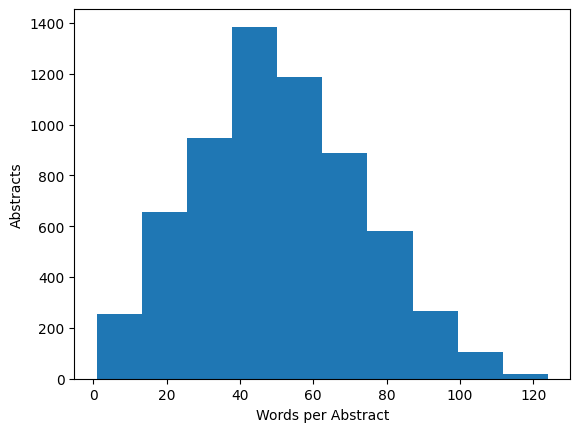

In [ ]:
# Show a Histogram of the word count per abstract
test_df['ABSTRACT_word_count'] = test_df['ABSTRACT'].apply(lambda x: len(str(x).split(" ")))
plt.hist(test_df['ABSTRACT_word_count'])
plt.xlabel("Words per Abstract")
plt.ylabel("Abstracts")
plt.show()

In [ ]:
# Look at two examples of processed vs. not processed
for i in range(2): # Use to see first Abstract
    abstract = old_test_df['ABSTRACT'].iloc[i]
    print(f'Abstract {i+1} (Not Processed):', abstract)
    abstract = test_df['ABSTRACT'].iloc[i]
    print(f'Abstract {i+1} (Processed):', abstract, '\n')

Abstract 1 (Not Processed):   Atmospheric modeling of low-gravity (VL-G) young brown dwarfs remains a
challenge. The presence of very thick clouds has been suggested because of
their extremely red near-infrared (NIR) spectra, but no cloud models provide a
good fit to the data with a radius compatible with evolutionary models for
these objects. We show that cloudless atmospheres assuming a temperature
gradient reduction caused by fingering convection provides a very good model to
match the observed VL-G NIR spectra. The sequence of extremely red colors in
the NIR for atmospheres with effective temperature from ~2000 K down to ~1200 K
is very well reproduced with predicted radii typical of young low-gravity
objects. Future observations with NIRSPEC and MIRI on the James Webb Space
Telescope (JWST) will provide more constrains in the mid-infrared, helping to
confirm/refute whether or not the NIR reddening is caused by fingering
convection. We suggest that the presence/absence of clouds wi

# Sentence Embedding (SBERT - "allenai-specter" and SBERT - "all-MiniLM-L6-v2" ) on Testing Sets

### Function to Find Top Document and Rank

In [ ]:
def find_top_doc(query, model, embeddings, doc_df, true_id):

  # Decide on model
  if model == 'specter':
    query_embedding = specter_sbert_model.encode(query)
  elif model == 'minilm':
    query_embedding = minilm_sbert_model.encode(query)
  else:
    print('Enter "specter" for allenai-specter and "minilm" for all-MiniLM-L6-v2')

  # Cosine similarity
  cosine_similarities = cosine_similarity(query_embedding.reshape(1, -1), embeddings)
  cosine_similarities = cosine_similarities[0]

  # Dot product
  dot_products = np.dot(embeddings, query_embedding)

  # Euclidean distance
  euclidean_distances = np.array([distance.euclidean(embedding, query_embedding) for embedding in embeddings])

  # Normalize all scores to get an average
  normalized_cosine = (cosine_similarities - np.min(cosine_similarities)) / (np.max(cosine_similarities) - np.min(cosine_similarities))
  normalized_dot = (dot_products - np.min(dot_products)) / (np.max(dot_products) - np.min(dot_products))
  normalized_euclidean = 1 - (euclidean_distances - np.min(euclidean_distances)) / (np.max(euclidean_distances) - np.min(euclidean_distances))
  doc_df['Geometric Mean'] = (normalized_cosine * normalized_dot * normalized_euclidean)**(1/3)

  # Sort by geometric mean
  sorted_df = doc_df.sort_values(by='Geometric Mean', ascending=False)

  # Get top doc ID
  top_doc_id = sorted_df.iloc[0]['ID']

  # Determine rank of original topic
  rank_doc_id = np.where(sorted_df['ID'] == true_id)[0][0] + 1

  return top_doc_id, rank_doc_id

### "all-MiniLM-L6-v2" Model

In [ ]:
# Make the model
minilm_sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Make and save the SBERT embeddings (if doesn't exist yet)
embeddings_path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/minilm_test_sbert_embeddings.npy'
if os.path.exists(embeddings_path):
  print('MiniLM (test) SBERT Embeddings already exist. Continue.')
  minilm_sbert_embeddings = np.load(embeddings_path)
else:
  minilm_sbert_embeddings = minilm_sbert_model.encode(test_df['ABSTRACT'], batch_size = 32, show_progress_bar=True)
  np.save(embeddings_path, minilm_sbert_embeddings)

MiniLM (test) SBERT Embeddings already exist. Continue.


In [ ]:
# Save ID's so it doesn't have to be run again
if 'MiniLM Predicted ID' not in test_df.columns or 'MiniLM Rank' not in test_df.columns:
  minilm_ids = []
  minilm_ranks = []

  # Place expected ID and true rank in column
  for title in range(test_df.shape[0]):
    test_id = test_df['ID'].iloc[title]
    query = test_df['TITLE'].iloc[title]
    query_embedding = minilm_sbert_model.encode(query)
    minilm_id_placeholder, minilm_rank_placeholder = find_top_doc(query, 'minilm', minilm_sbert_embeddings, test_df, test_id)
    minilm_ids.append(minilm_id_placeholder)
    minilm_ranks.append(minilm_rank_placeholder)


  test_df['MiniLM Predicted ID'] = minilm_ids
  test_df['MiniLM Rank'] = minilm_ranks
  test_df.to_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv', index=False)
else:
  print('Predicted MiniLM ID and rank columns exist.')

Predicted MiniLM ID and rank columns exist.


### "allenai-specter" Model

In [ ]:
# Make the model
specter_sbert_model = SentenceTransformer("allenai-specter")

In [ ]:
# Make and save the SBERT embeddings (if doesn't exist yet)
embeddings_path = '/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/specter_test_sbert_embeddings.npy'
if os.path.exists(embeddings_path):
  print('Specter (test) SBERT Embeddings already exist. Continue.')
  specter_sbert_embeddings = np.load(embeddings_path)
else:
  specter_sbert_embeddings = specter_sbert_model.encode(test_df['ABSTRACT'], batch_size = 32, show_progress_bar=True)
  np.save(embeddings_path, specter_sbert_embeddings)

Specter (test) SBERT Embeddings already exist. Continue.


In [ ]:
# Save ID's so it doesn't have to be run again
if 'Specter Predicted ID' not in test_df.columns or 'Specter Rank' not in test_df.columns:
  specter_ids = []
  specter_ranks = []

  # Place expected ID in column
  for title in range(test_df.shape[0]):
    test_id = test_df['ID'].iloc[title]
    query = test_df['TITLE'].iloc[title]
    query_embedding = specter_sbert_model.encode(query)
    specter_id_placeholder, specter_rank_placeholder = find_top_doc(query, 'specter', specter_sbert_embeddings, test_df, test_id)
    specter_ids.append(specter_id_placeholder)
    specter_ranks.append(specter_rank_placeholder)

  test_df['Specter Predicted ID'] = specter_ids
  test_df['Specter Rank'] = specter_ranks
  test_df.to_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv', index=False)
else:
  print('Predicted Specter ID and rank columns exist.')

Predicted Specter ID and rank columns exist.


### Determine Average Recall@1 and MRR From Saved Data, Delete Geometric Mean Column and Show Full Table

In [ ]:
# Determine Average Recall@1 and MRR
specter_recall_count = 0
specter_mrr_sum = 0
minilm_recall_count = 0
minilm_mrr_sum = 0
for row in range(len(test_df)):
  if test_df['ID'].iloc[row] == test_df['Specter Predicted ID'].iloc[row]:
    specter_recall_count += 1
  specter_mrr_sum += 1/(test_df['Specter Rank'].iloc[row])
  if test_df['ID'].iloc[row] == test_df['MiniLM Predicted ID'].iloc[row]:
    minilm_recall_count += 1
  minilm_mrr_sum += 1/(test_df['MiniLM Rank'].iloc[row])

specter_ave_recall = specter_recall_count / test_df.shape[0]
specter_mrr = specter_mrr_sum / test_df.shape[0]
minilm_ave_recall = minilm_recall_count / test_df.shape[0]
minilm_mrr = minilm_mrr_sum / test_df.shape[0]

print(f'Specter Average Recall@1: {specter_ave_recall:.4f}')
print(f'Specter MRR: {specter_mrr:.4f}')
print(f'Minilm Average Recall@1: {minilm_ave_recall:.4f}')
print(f'Minilm MRR: {minilm_mrr:.4f}')

Specter Average Recall@1: 0.3951
Specter MRR: 0.4912
Minilm Average Recall@1: 0.6394
Minilm MRR: 0.7191


In [ ]:
# Delete Geometric Mean Column and save file
if 'Geometric Mean' in test_df.columns:
  test_df = test_df.drop(['Geometric Mean'], axis=1)
test_df.to_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv', index=False)

# TF-IDF and TF on Testing Sets

### Initialization

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

### TF-IDF

In [ ]:
# Fill NaN values with an empty string
train_df['ABSTRACT'] = train_df['ABSTRACT'].fillna('')
test_df['ABSTRACT'] = test_df['ABSTRACT'].fillna('')

# Make vectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    sublinear_tf=True,
    use_idf=True,
    smooth_idf=True,
)

# Fit to training data
tfidf_vectorizer.fit(train_df['ABSTRACT'])

# Transform on test data
tfidf_test = tfidf_vectorizer.transform(test_df['ABSTRACT'])

# Transform test titles (queries)
tfidf_queries = tfidf_vectorizer.transform(test_df['TITLE'])

In [ ]:
# Fill NaN values with# Save ID's so it doesn't have to be run again
if 'TFIDF Predicted ID' not in test_df.columns or 'TFIDF Rank' not in test_df.columns:
  tfidf_ids = []
  tfidf_rank = []
  # Place expected ID and rank of actual ID in column
  for title in range(test_df.shape[0]):
  # for title in range(5):
    test_id = test_df['ID'].iloc[title]
    query = tfidf_queries[title]
    sim_scores = cosine_similarity(query, tfidf_test).flatten()
    best_index = sim_scores.argmax()
    predicted_id = test_df['ID'].iloc[best_index]

    sorted_indices = sim_scores.argsort()[::-1]
    sorted_ids = test_df['ID'].iloc[sorted_indices].tolist()
    rank = sorted_ids.index(test_id) + 1  # 1-based rank

    tfidf_ids.append(predicted_id)
    tfidf_rank.append(rank)

  test_df['TFIDF Predicted ID'] = tfidf_ids
  test_df['TFIDF Rank'] = tfidf_rank
  test_df.to_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv', index=False)
else:
  print('Predicted TFIDF ID and Rank Columns exist.')

### TF

In [ ]:
# Fill NaN values with an empty string
train_df['ABSTRACT'] = train_df['ABSTRACT'].fillna('')
test_df['ABSTRACT'] = test_df['ABSTRACT'].fillna('')

# Make vectorizer
tf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    sublinear_tf=True,
    use_idf=False,
    norm=None,
)

# Fit to training data
tf_vectorizer.fit(train_df['ABSTRACT'])

# Transform on test data
tf_test = tf_vectorizer.transform(test_df['ABSTRACT'])

# Transform test titles (queries)
tf_queries = tf_vectorizer.transform(test_df['TITLE'])

In [ ]:
# Save ID's so it doesn't have to be run again
if 'TF Predicted ID' not in test_df.columns or 'TF Rank' not in test_df.columns:
  tf_ids = []
  tf_rank = []
  # Place expected ID and rank of actual ID in column
  for title in range(test_df.shape[0]):
  # for title in range(5):
    test_id = test_df['ID'].iloc[title]
    query = tf_queries[title]
    sim_scores = cosine_similarity(query, tf_test).flatten()
    best_index = sim_scores.argmax()
    predicted_id = test_df['ID'].iloc[best_index]

    sorted_indices = sim_scores.argsort()[::-1]
    sorted_ids = test_df['ID'].iloc[sorted_indices].tolist()
    rank = sorted_ids.index(test_id) + 1  # 1-based rank

    tf_ids.append(predicted_id)
    tf_rank.append(rank)

  test_df['TF Predicted ID'] = tf_ids
  test_df['TF Rank'] = tf_rank
  test_df.to_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project3/test_processed.csv', index=False)
else:
  print('Predicted TF ID and Rank Columns exist.')

Predicted TF ID and Rank Columns exist.


### Determine Average Recall@1 and MRR From Saved Data

In [ ]:
# Determine Average Recall@1 and MRR
tf_recall_count = 0
tf_mrr_sum = 0
tfidf_recall_count = 0
tfidf_mrr_sum = 0
for row in range(len(test_df)):
  if test_df['ID'].iloc[row] == test_df['TF Predicted ID'].iloc[row]:
    tf_recall_count += 1
  tf_mrr_sum += 1/(test_df['TF Rank'].iloc[row])
  if test_df['ID'].iloc[row] == test_df['TF Predicted ID'].iloc[row]:
    tfidf_recall_count += 1
  tfidf_mrr_sum += 1/(test_df['TFIDF Rank'].iloc[row])

tf_ave_recall = tf_recall_count / test_df.shape[0]
tf_mrr = tf_mrr_sum / test_df.shape[0]
tfidf_ave_recall = tfidf_recall_count / test_df.shape[0]
tfidf_mrr = tfidf_mrr_sum / test_df.shape[0]

print(f'TF Average Recall@1: {tf_ave_recall:.4f}')
print(f'TF MRR: {tf_mrr:.4f}')
print(f'TFIDF Average Recall@1: {tfidf_ave_recall:.4f}')
print(f'TFIDF MRR: {tfidf_mrr:.4f}')

TF Average Recall@1: 0.5346
TF MRR: 0.6202
TFIDF Average Recall@1: 0.5346
TFIDF MRR: 0.6431


# Final Table and Results

In [ ]:
print(f'TF Average Recall@1: {tf_ave_recall:.4f}')
print(f'TF MRR: {tf_mrr:.4f}')
print(f'TFIDF Average Recall@1: {tfidf_ave_recall:.4f}')
print(f'TFIDF MRR: {tfidf_mrr:.4f}')
print(f'Specter Average Recall@1: {specter_ave_recall:.4f}')
print(f'Specter MRR: {specter_mrr:.4f}')
print(f'MiniLM Average Recall@1: {minilm_ave_recall:.4f}')
print(f'MiniLM MRR: {minilm_mrr:.4f}')

TF Average Recall@1: 0.5346
TF MRR: 0.6202
TFIDF Average Recall@1: 0.5346
TFIDF MRR: 0.6431
Specter Average Recall@1: 0.3951
Specter MRR: 0.4912
Minilm Average Recall@1: 0.6394
Minilm MRR: 0.7191


In [ ]:
test_df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,ABSTRACT_word_count,MiniLM Predicted ID,MiniLM Rank,Specter Predicted ID,Specter Rank,TF Predicted ID,TF Rank,TFIDF Predicted ID,TFIDF Rank
0,20212,Cloudless atmospheres for young low-gravity su...,modeling gravity remain challenge presence sug...,0,1,0,0,0,0,57,20212,1,20212,1,6482,2,6482,2
1,9175,Sample complexity of population recovery,population recovery estimate distribution inco...,1,0,1,1,0,0,84,9175,1,1181,101,9175,1,9175,1
2,13468,Regular Separability of Well Structured Transi...,investigate language recognize structure trans...,1,0,0,0,0,0,38,13468,1,19126,64,13468,1,20781,2
3,2165,Standard Zero-Free Regions for Rankin--Selberg...,simple standard region rankin selberg unitary ...,0,0,1,0,0,0,13,2165,1,5107,507,2165,1,2165,1
4,3619,Towards Visual Explanations for Convolutional ...,predictive neural interpretability several tec...,1,0,0,1,0,0,55,707,50,3619,1,14636,42,11161,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6287,5271,Right for the Right Reasons: Training Differen...,neural accurate supervised learning opacity di...,1,0,0,1,0,0,56,16803,6,6982,10,5815,8,17190,9
6288,4184,Online Human Gesture Recognition using Recurre...,gesture natural communication modality ability...,1,0,0,0,0,0,53,4184,1,4184,1,4184,1,4184,1
6289,3787,The null hypothesis of common jumps in case of...,absence univariate semimartingale absence comm...,0,0,1,0,0,0,35,12493,2,9437,2,3285,2,3285,2
6290,7906,Analysis of Coupled Scalar Systems by Displace...,potential functional introduce recently import...,1,0,1,0,0,0,31,7906,1,7906,1,7906,1,7906,1
